In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# {'a': {'b': 10, 'c': 20}, 'b': {'a': 10, 'd': 20}, 'c': {'a': 20, 'd': 30}, 'd': {'b': 20, 'c': 30}}
# ['a', 'b', 'c', 'd'], np.array([[0, 10, 20, inf], [10, 0, inf, 20], [20, inf, 0, 30], [inf, 20, 30, 0]])

class Graph:
    def __init__(self):
        """Неориентированный взвешенный граф.
        Представляется в виде {'a': {'b': 10, 'c': 20}, 'b': {'a': 10, 'd': 20}, 'c': {'a': 20, 'd': 30}, 'd': {'b': 20, 'c': 30}} (например)
        """
        self.graph = {}

    def add_node(self, v):
        "Добавление вершины с именем v."
        
        if v in self.graph.keys():
            return False

        self.graph[v] = {}

        return True


    def set_edge(self, u, v, w):
        """
        Задание ребра весом w между u и v.
        Предполагаем, что граф может быть мультиграфом, то есть содержать кратные рёбра.
        """
        
        if self.graph[u].get(v):
            self.graph[u][v] += [w]
            self.graph[v][u] += [w]
        else:
            self.graph[u][v] = [w]
            self.graph[v][u] = [w]


    def get_edge(self, u, v):
        "Получение веса ребра между u и v."
        
        try:
            return self.graph[u][v]

        except:
            return None


    @property
    def nodes(self):
        "Список вершин."
        return self.graph.keys()
    
    def _dfs(self, cur, visited):

        """
        Вспомогательная функция для проверки связности.
        Делает проход в глубину и запоминает посещённые вершины
        """

        visited[cur] = True

        for node in self.graph[cur]:

            if not visited[node]:
                self._dfs(node, visited)

    def is_connected(self):
        "Проверка связности."
        visited = {v: False for v in self.graph.keys()}

        self._dfs(next(iter(visited.keys())), visited)

        return all(visited.values())

    def _connected(self, u, v):

        "Проверка, связаны ли узлы u и v"

        visited = {v: False for v in self.graph.keys()}

        self._dfs(u, visited)

        return visited[v]


In [ ]:
class Circuit(Graph):
    def probe_field(self, u, v, u_voltage=0, v_voltage=1, check_connectivity=True):
        """
        Расчёт поля потенциалов при подключении источника тока в вершины u и v.
        Возвращает словарь {вершина: потенциал}.
        """

        if check_connectivity:
            assert(self.is_connected)

        relation = dict(zip(self.graph.keys(), range(len(self.graph))))  # Для удобного заполнения матрицы системы нам понадобится соответствие между элементами графа и индексами

        a, b = self._equations(u, v, u_voltage, v_voltage, relation)

        solution = np.linalg.solve(a, b)

        result = dict(zip(relation.keys(), solution))

        return result

    
    def calculate_currents(self, voltages):
        """
        Расчёт значений токов, исходя из значений поля потенциалов.
        Возващает словарь {вершина: {вершина_1: ток_1, ...}, ...}.
        """
        
        res = {}

        for node1 in self.graph.keys():

            res[node1] = {}

            for node2 in self.graph[node1].keys():

                res[node1][node2] = (-voltages[node2] + voltages[node1]) / self._parallel_resistance(node1, node2)

        return res
    
    def _parallel_resistance(self, u, v):
        """
        Вспомогательная функция для рассчёта сопротивления между двумя узлами, связанными параллельным соединением
        """

        res = 0

        for w in self.graph[u][v]:

            res += 1 / w

        return 1 / res


    def equivalent_resistance(self, u, v, check_connectivity=True):
        """
        Расчёт эквивалентного сопротивления между вершинами u и v.
        """
        
        if check_connectivity and not self._connected(u, v):
            return np.inf

        if u == v:
            return 0

        voltages = self.probe_field(u, v, 0, 1)
        currents = self.calculate_currents(voltages)

        return (voltages[v] - voltages[u]) / sum(currents[v].values())
    
    def _equations(self, u, v, u_voltage, v_voltage, relation):
        """
        Возвращает систему уравнений "Первое правило Кирхгофа".
        """

        n = len(relation)

        a = np.zeros((n, n))
        b = np.zeros(n)

        for node1 in self.graph.keys():

            if node1 == u or node1 == v:  # если текущий узел - один из тех, к которым подключено напряжение, то добавляем уравнение вида Fu = u_voltage
                a[relation[node1]][relation[node1]] = 1
                b[relation[node1]] = [u_voltage, v_voltage][node1 == v]
                continue

            for node2 in self.graph[node1]:  # иначе добавляем уравнение, соответствующее формуле, описанной в презентации
                
                weights = self.graph[node1][node2]

                for weight in weights:
                    a[relation[node1]][relation[node1]] += 1 / weight
                    a[relation[node1]][relation[node2]] -= 1 / weight

        return a, b

    
class Grid(Circuit):
    def __init__(self, width, height, resistance):
        """
        Прямоугольная решётка из width горизонтальных узлов и height вертикальных.
        """
        super().__init__()

        self.width = width
        self.height = height

        for i in range(height):
            for j in range(width):
                
                self.add_node((i, j))

        for i in range(height):
            for j in range(width):

                if j != width - 1:
                    self.set_edge((i, j), (i, j + 1), resistance)

                if i != height - 1:
                    self.set_edge((i, j), (i + 1, j), resistance)


    def plot_currents(self, currents):
        """
        Нарисовать картинку токов по заданному их распределению.
        """

        fig, axis = plt.subplots(figsize=(3 * self.width, 3 * self.height))  # Размер графика подстраивается под размер сети

        axis.set_xlim(-1, self.width)  # Задание отступов по краям
        axis.set_ylim(-1, self.height)

        max_cur = 0  # для корректного задания прозрачности стрелок будем использовать нормировку токов на единицу
        for _, tmp in currents.items():
            max_cur = max(max_cur, max(tmp.values())) 

        for n1, tmp in currents.items():
            for n2, cur in tmp.items():
                if cur <= 0:  # рисуем только прямые стрелки
                    continue

                dx = 0 if n1[0] == n2[0] else 1 if n1[0] < n2[0] else -1
                dy = 0 if n1[1] == n2[1] else 1 if n1[1] < n2[1] else -1

                axis.arrow(*n1, dx, dy, width=0.1, length_includes_head=True, alpha=cur/max_cur)

        plt.grid()
        plt.show()

    def equivalent_resistance(self, u, v):

        return super().equivalent_resistance(u, v, False)

In [ ]:
def horizontal_resistance_endless(resistance):

    g = Grid(50, 50, resistance)
    return g.equivalent_resistance((24, 24), (24, 25))

def diagonal_resistance_endless(resistance):

    g = Grid(50, 50, resistance)
    return g.equivalent_resistance((24, 24), (25, 25))

In [ ]:
eps = 1e-2  # значение для сравнения рассчитанного эквивалентного сопротивления и заданного в функции test_circuit

def create_circuit(n, weights):

    """
    Вспомогательная функция для создания цепи с количеством узлов n и весами, записанными в weights в формате, описанном в функции test_crcuit
    """

    cir = Circuit()

    for i in range(n):
            
        cir.add_node(i)
        
    for tmp in weights:

        a, b, w = tmp.split('-')
        w = float(w)

        cir.set_edge(ord(a) - ord('a'), ord(b) - ord('a'), w)

    return cir


def log(log_file, text):

    "Записать text в лог, представленный файлом log_file"

    log_file.write(text)

def test_circuit(path):

    """
    Функция для тестирования класса Circuit.
    Принимает файл, расположенный по пути path и отвечающий следующим требованиям:
        - первый символ в файле - символ-разделитель, который в дальнейшем будет обозначать переход от одного теста к другому
        - в каждом тесте первая строка задаёт количество узлов цепи (не более 27)
        - каждая последующая строка содержит запись в виде <имя узла 1>-<имя узла 2>-<сопротивление звена>
        - считается, что к узлу 'a' подключено напряжение 0, а к последнему узлу (в алфавитном порядке) - 1
        - узлы цепи имеют имена, соответствующие прописным буквам английского алфавита
        - последняя строка теста - верные значения потенциалов, соответсвующие узлам сетки в алфавитном порядке, записанные в виде <>-<>-...

    Возвращает True, если все ответы совпали, иначе - False.
    Сохраняет логи в файл log.txt
    """

    right = True

    with open(path, 'r') as file, open('log.txt', 'w') as log_file:

        splitter = file.read(1)

        tests = file.read().split(splitter)

        for num, test in enumerate(tests):

            #логирование
            log(log_file, "-" * 10 + '\n' + f"test {num + 1}\n\n")

            # парсим входные данные

            cur = list(filter(lambda x: x, test.split('\n')[1:]))  
            n = int(cur[0])
            res_theor = np.inf if cur[-1] == 'inf' else float(cur[-1])
            cur = cur[1:-1]

            #логирование
            log(log_file, "Circuit:\n" + '\n'.join(['\t' + edge for edge in cur]) + f"\n\nRight resistance: {res_theor}\n")

            cir = create_circuit(n, cur)
            res_calc = cir.equivalent_resistance(0, n - 1)

            #логирование
            log(log_file, f"Calculated resistance: {res_calc}\n")

            if abs(res_calc - res_theor) > eps:  # Если результат совпал, то переходим к следующему тесту, если нет - запишем дополнительные данные в лог

                right = False

                probes = cir.probe_field(0, n - 1)
                
                #логирование
                log(log_file, "Calculated voltages distribution:\n" + '\n'.join([f"\t{chr(node + ord('a'))}: {volt}" for node, volt in probes.items()]))

            log(log_file, "\n\n")

        return right


In [ ]:
# демонстрация функционала класса Graph

g = Graph()
g.add_node('a')
g.add_node('b')
g.add_node('c')

g.set_edge('a', 'b', 10)
g.set_edge('c', 'b', 5)

g.is_connected()

True

In [ ]:
g = Graph()
g.add_node('a')
g.add_node('b')
g.add_node('c')

g.set_edge('a', 'b', 10)

g.is_connected()

False

In [ ]:
# демонстрация функционала класса Circuit

g = Circuit()
g.add_node('a')
g.add_node('b')
g.add_node('c')
g.add_node('d')

g.set_edge('a', 'b', 10)
g.set_edge('a', 'c', 20)
g.set_edge('b', 'd', 20)
g.set_edge('c', 'd', 30)

In [ ]:
probes = g.probe_field('a', 'd')
print(probes)

{'a': 0.0, 'b': 0.3333333333333333, 'c': 0.39999999999999997, 'd': 1.0}


In [ ]:
g.calculate_currents(probes)

{'a': {'b': -0.03333333333333333, 'c': -0.019999999999999997},
 'b': {'a': 0.03333333333333333, 'd': -0.03333333333333334},
 'c': {'a': 0.019999999999999997, 'd': -0.020000000000000004},
 'd': {'b': 0.03333333333333334, 'c': 0.020000000000000004}}

In [ ]:
g.equivalent_resistance('a', 'd')

18.749999999999996

In [ ]:
# Проверка добавления параллельного соединения

g = Circuit()
g.add_node('a')
g.add_node('b')

g.set_edge('a', 'b', 5)
g.set_edge('a', 'b', 10)

In [ ]:
probes = g.probe_field('a', 'b')
print(probes)

{'a': 0.0, 'b': 1.0}


In [ ]:
g.calculate_currents(probes)

{'a': {'b': -0.30000000000000004}, 'b': {'a': 0.30000000000000004}}

In [ ]:
g.equivalent_resistance('a', 'b')

3.333333333333333

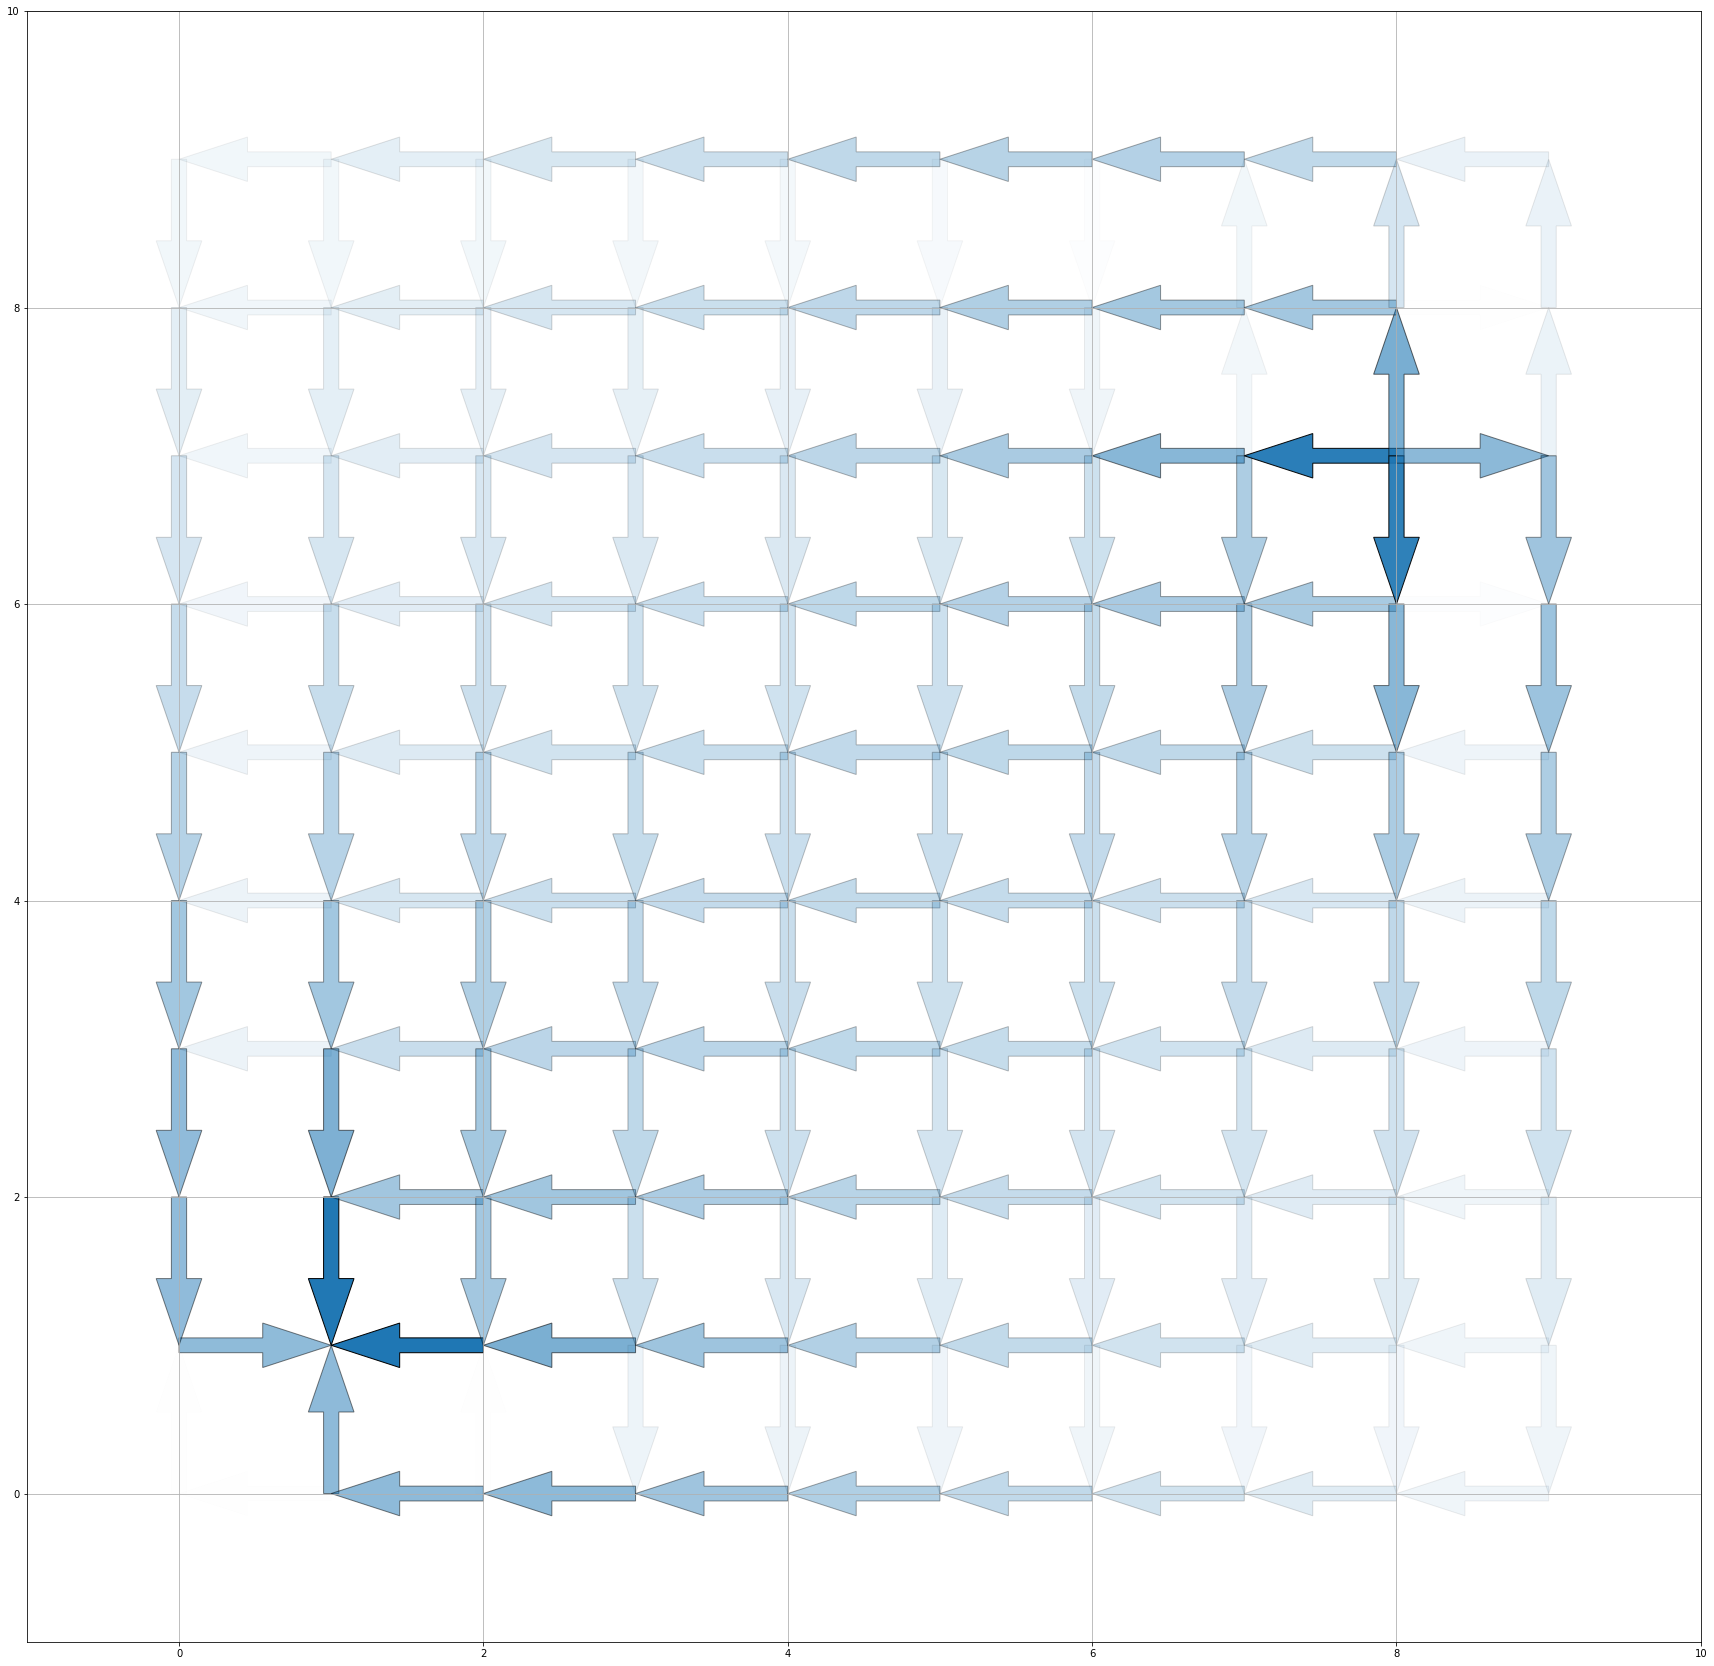

In [ ]:
# демонстрация функционала класса Grid

g = Grid(10, 10, 1)

currents = g.calculate_currents(g.probe_field((1, 1), (8, 7)))

g.plot_currents(currents)

In [ ]:
# Запустим тесты

test_circuit('tests.txt')

True

In [ ]:
print(horizontal_resistance_endless(1))
print(diagonal_resistance_endless(1))

0.5002191798304995
0.637057770406344
